In [81]:
#Load the neccessary libraries required
import numpy as np 
import pandas as pd 
from nltk.tokenize import WordPunctTokenizer, TreebankWordTokenizer    
from nltk.stem import WordNetLemmatizer
import string
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,SpatialDropout1D,LSTM,Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from predict_rnn_news import predict_news_rnn
from predict_ensemble_news import predict_news_ensemble
from sklearn.metrics import classification_report,accuracy_score

In [93]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
#Load the dataset of fake news
fake =pd.read_csv("Fake.csv")

In [3]:
#Load the dataset of real news
real=pd.read_csv("True.csv")

In [4]:
# Lets look at the information about the data
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [5]:
#Setting Target Class as zero
fake["class"]=0.0

In [6]:
#Selecting the required columns
fake=fake[["text","class"]]

In [7]:
#Lemantizer to lemmantize the words
lem = WordNetLemmatizer()
#To lower the case of the text data
fake['text']=fake['text'].str.lower()
# Remove Punctuations
fake['text']=fake['text'].str.replace(r'[^\w\d\s]',' ')
#Remove the whitespaces
fake['text']=fake['text'].str.replace(r'\s+',' ')
#Removing links
fake['text']=fake['text'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',' ')
#Replacing the numbericals with num string
fake['text']=fake['text'].str.replace(r'\d+(\.\d+)?','num')
stop_words = set(stopwords.words('english'))
#Removing the stop words
fake['text']=fake['text'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop_words))
#Stemming the words
fake['text']=fake['text'].apply(lambda x: ' '.join(lem.lemmatize(term) for term in str(x).split()))

In [8]:
# This cell filters out the rows where there were no publishers mentioned
unknown_publishers = []
for index,row in enumerate(real.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of piblication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)
publisher = []
tmp_text = []
for index,row in enumerate(real.text.values):
    if index in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)
        
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])


In [9]:
real["text"] = tmp_text
del publisher, tmp_text, record, unknown_publishers
real['class']=1.0
real=real[['text','class']]

In [84]:
#Lowering the case of the text data
real['text']=real['text'].str.lower()
# Remove Punctuations
real['text']=real['text'].str.replace(r'[^\w\d\s]',' ')
#Remove the whitespaces
real['text']=real['text'].str.replace(r'\s+',' ')
#Removing links
real['text']=real['text'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',' ')
real['text']=real['text'].str.replace(r'\d+(\.\d+)?','num')
#Remove tags from the text
real['text']=real['text'].str.replace(r'\@[a-zA-Z]+','')
stop_words = set(stopwords.words('english'))
#Removing the stop words
real['text']=real['text'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop_words))
#Stemming the words
real['text']=real['text'].apply(lambda x: ' '.join(lem.lemmatize(term) for term in str(x).split()))

In [11]:
#Lets concatenate both the datasets
concat=pd.concat([real,fake],ignore_index=True)
del real,fake

In [12]:
#Randomly shuffle and distribute the data so the training can be done efficiently
concat = concat.sample(frac=1).reset_index(drop=True)

In [13]:

count = concat.text.str.split().apply(len).value_counts()
count.index = count.index.astype(str) + ' words:'
count.sort_index(inplace=True)
count

0 words:       632
1 words:        17
10 words:       56
100 words:      55
1002 words:      2
              ... 
990 words:       2
991 words:       2
993 words:       2
994 words:       3
999 words:       1
Name: text, Length: 1067, dtype: int64

In [30]:
# Vectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2),max_features=5000)

In [31]:
# Lets get the vectors of text based on term frequency
feature_vector=tfidf.fit_transform(concat['text']).todense()


In [23]:
# Lets look at the vocabulary
tfidf_vocab=tfidf.vocabulary_
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}
tfidf_reversed_vocab 

{3963: 'senate',
 3665: 'republican',
 2749: 'monday',
 3622: 'released',
 679: 'change',
 1939: 'healthcare',
 456: 'bill',
 2109: 'including',
 4082: 'six',
 2755: 'month',
 4815: 'waiting',
 3209: 'period',
 3190: 'people',
 2453: 'let',
 2165: 'insurance',
 974: 'coverage',
 2924: 'num',
 1051: 'day',
 4666: 'two',
 4826: 'want',
 1800: 'get',
 241: 'appeared',
 122: 'aimed',
 1288: 'dropping',
 1936: 'health',
 419: 'begin',
 843: 'concern',
 3139: 'part',
 599: 'cancel',
 2750: 'monetary',
 3183: 'penalty',
 1016: 'current',
 2405: 'law',
 2358: 'known',
 3000: 'obamacare',
 2416: 'leader',
 1992: 'hold',
 4803: 'vote',
 2307: 'july',
 4206: 'start',
 1381: 'end',
 4859: 'week',
 3967: 'senate republican',
 1940: 'healthcare bill',
 4083: 'six month',
 2932: 'num day',
 4670: 'two month',
 1938: 'health insurance',
 2308: 'july num',
 2626: 'may',
 4127: 'soon',
 4647: 'tuesday',
 464: 'bipartisan',
 3433: 'proposal',
 4939: 'would',
 2567: 'make',
 1306: 'easier',
 3067: 'operat

In [24]:
#Now time to split to the data for actual training
x = pd.DataFrame(feature_vector)
y= concat['class'] 

In [25]:
# Train-Test_split 
X_train,X_test,Y_train,Y_test = train_test_split(x,y,test_size=.3,random_state=1)
X_train

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
3603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
43687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.082695,0.0,0.0
36456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
42624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
10233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
32511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
12172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.179403,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [26]:
# Lets train the Logistic Regression 
lr = LogisticRegression()
lr.fit(X_train,Y_train)
# Check score on test set
lr.score(X_test,Y_test)

0.9802524127691166

In [76]:
#Training score
lr.score(X_train,Y_train)

0.9868270332187858

In [75]:
#Save the vectorizer
with open('vectorizer.pickle', 'wb') as handle:
        pickle.dump(tfidf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [49]:
#Lets train the SGD Classifier
sgd = SGDClassifier(learning_rate='adaptive', eta0=0.05)
sgd.fit(X_train,Y_train)
#Check validation Score
sgd.score(X_test,Y_test)

0.9824053452115813

In [85]:
# Lets train the RandomForest classifier
rf = RandomForestClassifier()
rf.fit(X_train,Y_train)
#Lets check validation score
rf.score(X_test,Y_test)

0.9855233853006682

In [86]:
#Lets check training score
rf.score(X_train,Y_train)

0.9999681812396589

In [87]:
#Save the Ensemble Model
with open('Ensemble_model.pickle', 'wb') as handle:
        pickle.dump(rf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [89]:
# Lets performance reports of the models trained above
models = {'Logistic Regression' : lr , 'SGD Classifier':sgd,'Random Forest Classifier':rf}
def model_details(m):
    for i in m:
        print(i)
        print('-'*100)
        prediction = m[i].predict(X_test)
        print('Classification Report')        
        cr = classification_report(Y_test,prediction,output_dict=True)
        print(pd.DataFrame(cr).transpose())
        print('='*100)
        accuracy = accuracy_score(Y_test.values.ravel(),prediction)
        print('Accuracy Score :  ',accuracy)
        print('='*100)
model_details(models)

Logistic Regression
----------------------------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score       support
0.0            0.985978  0.976201  0.981065   7059.000000
1.0            0.974078  0.984714  0.979367   6411.000000
accuracy       0.980252  0.980252  0.980252      0.980252
macro avg      0.980028  0.980457  0.980216  13470.000000
weighted avg   0.980314  0.980252  0.980257  13470.000000
Accuracy Score :   0.9802524127691166
SGD Classifier
----------------------------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score       support
0.0            0.987564  0.978751  0.983138   7059.000000
1.0            0.976830  0.986430  0.981607   6411.000000
accuracy       0.982405  0.982405  0.982405      0.982405
macro avg      0.982197  0.982590  0.982372  13470.000000
weighted avg   0.982456  0.982405  0.982409

In [100]:
def plot_learning_curve(X, y):
    plt.style.use('seaborn')
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    train_sizes = [1, 100, 500, 2000, 5000,10000, 30000, 35918]
    # First Estimator
    train_sizes, train_scores, validation_scores = learning_curve(LogisticRegression(),x,y,
                                                              train_sizes = train_sizes, cv = 5, scoring = 'accuracy')
    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)
    ax1.plot(train_sizes, train_scores_mean, label = 'Training error')
    ax1.plot(train_sizes, validation_scores_mean, label = 'Validation error')
    ax1.set_ylabel('Accuracy', fontsize = 14)
    ax1.set_xlabel('Training set size', fontsize = 14)
    ax1.set_title('Learning curves for a Logistic model', fontsize = 18, y = 1.03)
    ax1.legend(loc="best")
    ax1.grid(True)
    # Second Estimator
    train_sizes = [1, 100, 500, 2000, 5000,10000, 30000, 35918]
    train_sizes, train_scores, validation_scores = learning_curve(SGDClassifier(),x,y,
                                                              train_sizes = train_sizes, cv = 5, scoring = 'accuracy')
    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)
    ax2.plot(train_sizes, train_scores_mean, label = 'Training error')
    ax2.plot(train_sizes, validation_scores_mean, label = 'Validation error')
    ax2.set_ylabel('Accuracy', fontsize = 14)
    ax2.set_xlabel('Training set size', fontsize = 14)
    ax2.set_title('Learning curves for a SGD model', fontsize = 18, y = 1.03)
    ax2.legend(loc="best")
    ax2.grid(True)
    
    # Third Estimator
    train_sizes = [1, 100, 500, 2000, 5000,10000, 30000, 35918]
    train_sizes, train_scores, validation_scores = learning_curve(RandomForestClassifier(),x,y,
                                                              train_sizes = train_sizes, cv = 5, scoring = 'accuracy')
    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)
    ax3.plot(train_sizes, train_scores_mean, label = 'Training error')
    ax3.plot(train_sizes, validation_scores_mean, label = 'Validation error')
    ax3.set_ylabel('Accuracy', fontsize = 14)
    ax3.set_xlabel('Training set size', fontsize = 14)
    ax3.set_title('Learning curves for a Random Forest model', fontsize = 18, y = 1.03)
    ax3.legend(loc="best")
    ax3.grid(True)
    
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Vatsal Tulshyan\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

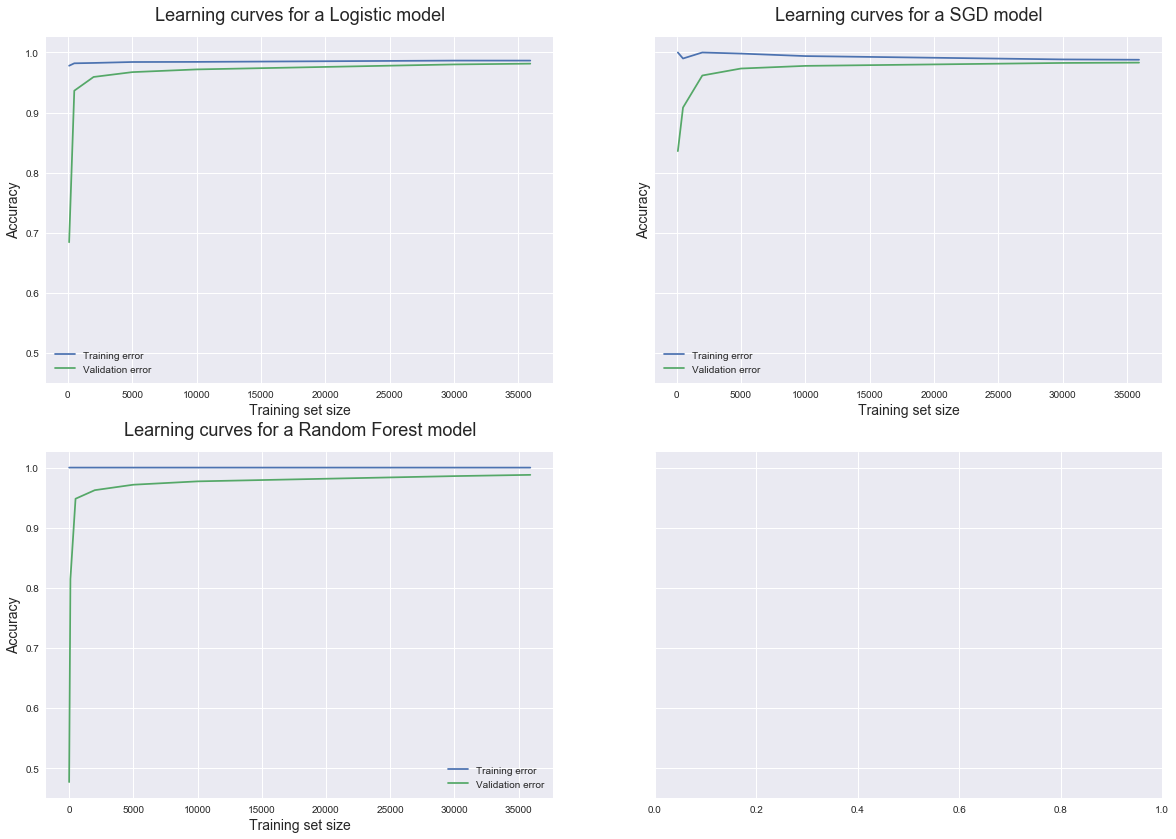

In [101]:
plot_learning_curve(x, y)

In [64]:
#This is the number of vocabulary we can have.
MAX_NB_WORDS = 50000
# Max number of words in the whole dataset in any row
MAX_SEQUENCE_LENGTH = 1000
# This is fixed.
EMBEDDING_DIM = 100
# Lets intialise the tokenizer with filters on punctuation and lower the case of the input
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
# Fit on the text of the data
tokenizer.fit_on_texts(concat.text.values)
#Lets check for the total unique token in the corpus
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 108605 unique tokens.


In [70]:
# Saving the tokenizer as pikle file
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
# Time to pad the sequences to the maximum length of the sequence
X = tokenizer.texts_to_sequences(concat.text.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
X= np.array(X,dtype=np.float32)

In [23]:
# Convert it into dummy variable of the output class
Y = pd.get_dummies(concat['class'].values)
print('Shape of label tensor:', Y.shape)
#Splitting it into train and test set.. HOLDOUT sets.
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
#Lets check the shape if everything is fine
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

Shape of label tensor: (44898, 2)
(40408, 1000) (40408, 2)
(4490, 1000) (4490, 2)


In [24]:
# Need to cast it into float values because would help in training the neural networks and would support TPU as well.
X_train=tf.cast(X_train,tf.float32)
Y_train=tf.cast(Y_train,tf.float32)
X_test=tf.cast(X_test,tf.float32)
Y_test=tf.cast(Y_test,tf.float32)

In [18]:
# Lets define the architecture
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
569/569 [==============================] - 3360s 6s/step - loss: 0.1184 - accuracy: 0.9587 - val_loss: 0.0492 - val_accuracy: 0.9847
Epoch 2/5
569/569 [==============================] - 3154s 6s/step - loss: 0.0287 - accuracy: 0.9913 - val_loss: 0.0393 - val_accuracy: 0.9879
Epoch 3/5
569/569 [==============================] - 3310s 6s/step - loss: 0.0162 - accuracy: 0.9951 - val_loss: 0.0483 - val_accuracy: 0.9879
Epoch 4/5
569/569 [==============================] - 3454s 6s/step - loss: 0.0097 - accuracy: 0.9973 - val_loss: 0.0420 - val_accuracy: 0.9889
Epoch 5/5
569/569 [==============================] - 3273s 6s/step - loss: 0.0090 - accuracy: 0.9973 - val_loss: 0.0557 - val_accuracy: 0.9884


In [21]:
#Saving the Model
model.save("saved_model1")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model1\assets


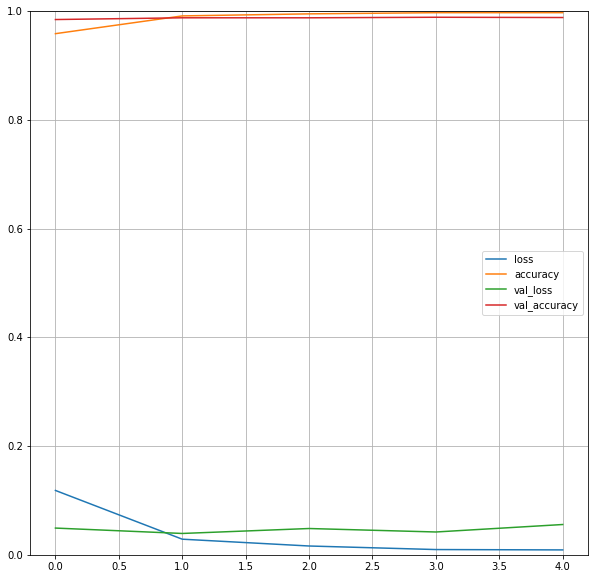

In [19]:
#Lets look at the performance of the model

pd.DataFrame(history.history).plot(figsize=(10,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [22]:
acc=model.evaluate(X_test,Y_test)
print('Loss : {} ,Accuracy : {}'.format(acc[0],acc[1]*100))


141/141 [==============================] - 30s 216ms/step - loss: 0.0562 - accuracy: 0.9895
Loss : 0.05619898438453674 ,Accuracy : 98.95322918891907


In [72]:
text ="Rapper Kanye West signalled he no longer supports US President Donald Trump and said he had entered the presidential race to win it, in an interview published on Wednesday.West, previously a vocal supporter of Trump, announced on Saturday that he would run for president in 2020.I am taking the red hat off, with this interview, West told Forbes, referring to Trumps trademark red Make America Great Again baseball cap. Like anything Ive ever done in my life, Im doing (this) to win,he added.He told the magazine he will run under a new banner - the Birthday Party. West and his reality TV star wife Kim Kardashian West have visited Trump in the White House. West denied that his aim was to split the Black vote and hurt the chances of Trump's Democratic opponent, Joe Biden. It was a form of racism and white supremacy to suggest all Black people should support the Democrats, he said"
# Outputting same prediction for every input
predict_news_rnn(text)

[[6302, 11880, 681, 19897, 831, 71, 2049, 6, 19, 2, 3, 2155, 79, 369, 231, 195, 912, 127, 681, 818, 3811, 189, 2, 508, 426, 7, 258, 6, 1, 38968, 358, 1100, 2941, 195, 681, 29, 5839, 1244, 7262, 1100, 42, 77, 287, 4206, 2334, 27, 449, 29440, 325, 397, 144, 18797, 231, 291, 30897, 29, 1714, 258, 13, 3712, 4492, 26, 681, 801, 624, 776, 647, 1290, 16196, 681, 2235, 2, 30, 17, 681, 664, 1709, 2428, 139, 47, 1264, 774, 2, 83, 961, 1008, 1620, 757, 1267, 30, 4464, 2133, 139, 8, 71, 3]]
[[1.7520511e-05 9.9998248e-01]]
Real News!!


In [79]:
# Prediction is same 
predict_news_ensemble('text')

array([0.])

In [80]:
predict_news_ensemble(fake['text'][1])

array([0.])